
# AI Camp 2020 Kickoff
### Agenda
* First
* Second

In [ ]:
print("Herzlich willkommen!")

# Check this out! $e^2_2+x$

In [ ]:
def test():
    print("YO")

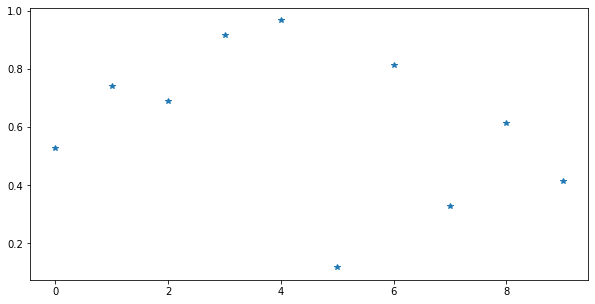

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
a = plt.plot(np.random.rand(10), "*")

In [10]:
print("Vielen Dank für die Aufmerksamkeit :)")
test()

Vielen Dank für die Aufmerksamkeit :)


NameError: name 'test' is not defined